#Importing the libraries

In [19]:
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam

# Importing the dataset

 feature

```
 1-Age: Age of the individual in years.

 2-Gender:Gender of the individual (e.g., Male, Female).

 3-Weight (kg): Weight of the individual in kilograms.

 4-Height (m): Height of the individual in meters.

 5-Max_BPM:Maximum heartbeats per minute recorded during exercise.

 6-Avg_BPM: Average heartbeats per minute during a workout session.

 7-Resting_BPM:Resting heartbeats per minute.

 8-Session_Duration (hours):Duration of the workout session in hours.

 9-Workout_Type:Type of workout performed (e.g., Cardio, Strength, Yoga).

 10-Fat_Percentage:Percentage of body fat.

 11-Water_Intake (liters):Water intake in liters during or after the workout.

 12-Workout_Frequency (days/week): Number of days per week the individual exercises.

 13-Experience_Level:Level of fitness experience (e.g., Beginner, Intermediate, Advanced).

 14-BMI:Body Mass Index, calculated as weight (kg) / height (m)^2.

target

 #Calories_Burned:Total calories burned during a workout session.

```



In [20]:
# Load the dataset into a DataFrame (assuming the file is named 'fitness_tracker_dataset.csv')
dataset = pd.read_csv('gym_members_exercise_tracking_synthetic_data.csv')

features = [
    "Age","Gender","Weight (kg)", "Height (m)", "Max_BPM", "Avg_BPM",
    "Resting_BPM", "Session_Duration (hours)", "Experience_Level" ,
    "Workout_Frequency (days/week)", "Fat_Percentage", "BMI" ,"Water_Intake (liters)" ,
    "Workout_Type"
]

target = "Calories_Burned"

dataset.describe(include='all')





,Age,Gender,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Workout_Type,Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI
count,1790.000000,1729,1778.000000,1774.000000,1779,1770.000000,1781.000000,1777.000000,1777.000000,1739,1784.000000,1776.000000,1742.000000,1743.000000,1770.000000
unique,NaN,2,NaN,NaN,42,NaN,NaN,NaN,NaN,7,NaN,NaN,NaN,NaN,NaN
top,NaN,Female,NaN,NaN,192,NaN,NaN,NaN,NaN,Strength,NaN,NaN,NaN,NaN,NaN
freq,NaN,872,NaN,NaN,69,NaN,NaN,NaN,NaN,464,NaN,NaN,NaN,NaN,NaN
mean,34.475419,NaN,67.606637,1.739233,NaN,146.259322,63.951151,1.391598,1033.698931,NaN,23.509361,2.706644,3.339265,1.823867,19.957774
std,12.315728,NaN,19.861408,0.123892,NaN,15.219516,7.936502,0.372342,328.049662,NaN,5.865557,0.710224,0.947955,0.746568,6.573175
min,18.000000,NaN,40.000000,1.500000,NaN,120.000000,50.000000,0.500000,303.000000,NaN,10.000000,1.500000,2.000000,1.000000,12.320000
25%,23.000000,NaN,52.300000,1.650000,NaN,133.250000,57.000000,1.130000,794.000000,NaN,20.500000,2.100000,3.000000,1.000000,14.780000
50%,33.000000,NaN,65.300000,1.730000,NaN,146.000000,65.000000,1.370000,1030.000000,NaN,24.300000,2.800000,3.000000,2.000000,18.690000
75%,45.000000,NaN,80.100000,1.820000,NaN,160.000000,72.000000,1.640000,1249.000000,NaN,27.500000,3.400000,4.000000,2.000000,23.517500


Cleaning Data

In [21]:
# critical columns: drop rows if NaN exists in any of these
drop_columns = [
    "Gender",
    "Calories_Burned",
]

mode_value_columns = [
    "Workout_Type",
]


# Avg_BPM must be calculated as:
# mean_ratio = (Max_BPM / Avg_BPM) across all rows
# Then Avg_BPM = Max_BPM / mean_ratio

# BMI:Body Mass Index, calculated as weight (kg) / height (m)^2.

dataset = dataset.dropna(subset=drop_columns)

dataset['Workout_Type'] = dataset['Workout_Type'].str.replace(r'^[\\n\\t\r]+', '', regex=True)

# Convert all values in 'Workout_Type' to title case
dataset['Workout_Type'] = dataset['Workout_Type'].str.title()
dataset['Gender'] = dataset['Gender'].str.title()

print(dataset['Workout_Type'].unique())
print(dataset['Gender'].unique())

if dataset['Workout_Type'].isnull().sum() > 0:
    # Group by Gender and calculate the mode of 'Workout_Type' for each gender
    mode_by_gender = dataset.groupby('Gender')['Workout_Type'].apply(lambda x: x.mode()[0])

    # Fill missing values in 'Workout_Type' based on the gender-specific mode
    for gender, mode_value in mode_by_gender.items():
        dataset.loc[(dataset['Workout_Type'].isnull()) & (dataset['Gender'] == gender), 'Workout_Type'] = mode_value


for column in mode_value_columns:
    if dataset[column].isnull().sum() > 0:
        mode_value = dataset[column].mode()[0]  # Get the most frequent value
        dataset[column] = dataset[column].fillna(mode_value)

dataset["Max_BPM"] = pd.to_numeric(dataset["Max_BPM"], errors='coerce')
dataset["Avg_BPM"] = pd.to_numeric(dataset["Avg_BPM"], errors='coerce')

# Set null values in Max_BPM to the mean before proceeding
if dataset["Max_BPM"].isnull().sum() > 0:
    dataset["Max_BPM"] = dataset["Max_BPM"].fillna(dataset["Max_BPM"].mean())

# calculate Avg_BPM using the relationship between max_BPM and avg_BPM
if "Avg_BPM" in dataset.columns and dataset["Avg_BPM"].isnull().sum() > 0:
    # calculate the mean ratio of Max_BPM to Avg_BPM for non Nan rows
    mean_ratio = (dataset["Max_BPM"] / dataset["Avg_BPM"]).mean()
    # Fill missing Avg_BPM using Max_BPM / mean_ratio
    dataset["Avg_BPM"] = dataset["Avg_BPM"].fillna(dataset["Max_BPM"] / mean_ratio)

# Repeat the calculation process up to 3 times
for _ in range(3):
    # Iterate through rows to handle missing values
    for index, row in dataset.iterrows():
        # Check how many of BMI, Height, and Weight are missing
        missing_count = row[['BMI', 'Height (m)', 'Weight (kg)']].isnull().sum()

        if missing_count == 1:
            # If only one is missing, calculate it using the formula
            if pd.isnull(row['BMI']) and not pd.isnull(row['Height (m)']) and not pd.isnull(row['Weight (kg)']):
                dataset.loc[index, 'BMI'] = row['Weight (kg)'] / (row['Height (m)'] ** 2)
            elif pd.isnull(row['Height (m)']) and not pd.isnull(row['BMI']) and not pd.isnull(row['Weight (kg)']):
                dataset.loc[index, 'Height (m)'] = (row['Weight (kg)'] / row['BMI']) ** 0.5
            elif pd.isnull(row['Weight (kg)']) and not pd.isnull(row['BMI']) and not pd.isnull(row['Height (m)']):
                dataset.loc[index, 'Weight (kg)'] = row['BMI'] * (row['Height (m)'] ** 2)

        elif missing_count > 1:
            # If more than one is missing, choose one to set to the mean
            if pd.isnull(row['BMI']):
                dataset.loc[index, 'BMI'] = dataset['BMI'].mean()
            elif pd.isnull(row['Height (m)']):
                dataset.loc[index, 'Height (m)'] = dataset['Height (m)'].mean()
            elif pd.isnull(row['Weight (kg)']):
                dataset.loc[index, 'Weight (kg)'] = dataset['Weight (kg)'].mean()

# Print summary to verify results
print(dataset[['BMI', 'Height (m)', 'Weight (kg)']].isnull().sum())


#if there is still null , calculate it as the mean
dataset.fillna(dataset.select_dtypes(include=['number']).mean(), inplace=True)

dataset.describe()




<ipython-input-21-b02eadd41ba7>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Workout_Type'] = dataset['Workout_Type'].str.replace(r'^[\\n\\t\r]+', '', regex=True)
<ipython-input-21-b02eadd41ba7>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Workout_Type'] = dataset['Workout_Type'].str.title()
<ipython-input-21-b02eadd41ba7>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

['Strength' 'Cardio' 'Hiit' 'Yoga' nan]
['Female' 'Male']
BMI            0
Height (m)     0
Weight (kg)    0
dtype: int64


,Age,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI
count,1708.000000,1708.000000,1708.000000,1708.000000,1708.000000,1708.000000,1708.000000,1708.000000,1708.000000,1708.000000,1708.000000,1708.000000,1708.000000
mean,34.443463,67.543874,1.743323,180.221429,146.068868,63.828504,1.392805,1034.652810,23.500236,2.711922,3.342615,1.822249,20.021679
std,12.251157,19.857470,0.137150,11.401488,15.155209,7.919567,0.370430,326.392286,5.851232,0.705004,0.931792,0.732436,6.657647
min,18.000000,29.218112,1.305875,160.000000,120.000000,50.000000,0.500000,303.000000,10.000000,1.500000,2.000000,1.000000,12.209640
25%,23.000000,52.375000,1.650000,170.000000,133.000000,57.000000,1.140000,796.750000,20.600000,2.100000,3.000000,1.000000,14.800000
50%,33.000000,65.200000,1.730000,180.221429,146.000000,64.000000,1.380000,1031.500000,24.200000,2.800000,3.000000,2.000000,18.685000
75%,45.000000,80.025000,1.830000,190.000000,159.000000,72.000000,1.630000,1249.000000,27.400000,3.300000,4.000000,2.000000,23.562500
max,59.000000,129.900000,3.141549,199.000000,169.000000,74.000000,2.000000,1783.000000,35.000000,3.700000,5.000000,3.000000,49.840000


**Data exploring**

In [ ]:
# Boxplot for Workout_Type vs Calories_Burned
print("Range of Calories_Burned:")
print(f"Min: {dataset['Calories_Burned'].min()}, Max: {dataset['Calories_Burned'].max()}")

print("\nStandard Deviation of Calories_Burned:")
print(dataset['Calories_Burned'].std())


plt.figure(figsize=(10, 6))
sns.boxplot(data=dataset, x="Workout_Type", y="Calories_Burned", palette="Set1")
plt.title("Calories Burned Distribution by Workout Type")
plt.xlabel("Workout Type")
plt.ylabel("Calories Burned")
plt.show()

# Boxplot for Gender vs Workout_Type

plt.figure(figsize=(10, 6))
sns.boxplot(data=dataset, x="Gender", y="Workout_Type", palette="Set1")
plt.title("Gender Distribution by Workout Type")
plt.xlabel("Gender Type")
plt.ylabel("Workout_Type")
plt.show()

# Boxplot for Gender vs Calories Burned
plt.figure(figsize=(10, 6))
sns.boxplot(data=dataset, x="Gender", y="Calories_Burned", palette="Set2")
plt.title("Calories Burned by Gender")
plt.xlabel("Gender")
plt.ylabel("Calories Burned")
plt.show()


# Boxplot for Workout_Type vs  Workout_Frequency

plt.figure(figsize=(10, 6))
sns.boxplot(data=dataset, x="Workout_Type", y="Workout_Frequency (days/week)", palette="Set1")
plt.title("Workout frequency Distribution by Workout Type")
plt.xlabel("Workout_Type")
plt.ylabel("Workout_Frequency (days/week)")
plt.show()



# Line plot for Avg_BPM vs Water_Intake (liters)
plt.figure(figsize=(10, 6))
sns.lineplot(x="Avg_BPM", y="Water_Intake (liters)", data=dataset, palette="Set1", marker="o")
plt.title("Avg_BPM vs Water_Intake (liters) Distribution")
plt.xlabel("Avg_BPM")
plt.ylabel("Water_Intake (liters)")
plt.show()

# Line plot for Calories_Burned vs Water_Intake (liters)
plt.figure(figsize=(10, 6))
sns.lineplot(x="Calories_Burned", y="Water_Intake (liters)", data=dataset, palette="Set1", marker="o")
plt.title("Calories_Burned vs Water_Intake (liters) Distribution")
plt.xlabel("Calories_Burned")
plt.ylabel("Water_Intake (liters)")
plt.show()


# Boxplot for Experience Level vs Calories Burned

plt.figure(figsize=(10, 6))
sns.boxplot(data=dataset, x="Experience_Level", y="Calories_Burned", palette="Set2")
plt.title("Calories Burned by Experience Level")
plt.xlabel("Experience Level")
plt.ylabel("Calories Burned")
plt.show()

# Bar plot for Workout Type vs Avg_BPM
plt.figure(figsize=(10, 6))
sns.lineplot(data=dataset, x="Session_Duration (hours)", y="Calories_Burned", palette="Set1")
plt.title("Session_Duration (hours)")
plt.xlabel("Session_Duration (hours)")
plt.ylabel("Calories_Burned")
plt.show()


# Violin Plot for Fat Percentage by Workout Type
plt.figure(figsize=(10, 6))
sns.barplot(data=dataset, x="Workout_Type", y="Fat_Percentage", palette="Set1")
plt.title("Fat Percentage Distribution by Workout Type")
plt.xlabel("Workout Type")
plt.ylabel("Fat Percentage")
plt.show()



# Encoding Categorical Data

encoding (string -> int)

In [22]:
# One-Hot Encoding for 'Gender'
dataset = pd.get_dummies(dataset, columns=["Gender"], drop_first=True)

# One-Hot Encoding for 'Workout_Type'
dataset = pd.get_dummies(dataset, columns=["Workout_Type"], drop_first=True)

# Display the updated dataset to confirm the encoding
print(dataset.head())
dataset.describe()


    Age  Weight (kg)  Height (m)  Max_BPM  Avg_BPM  Resting_BPM  \
0  34.0         86.7        1.86    174.0    152.0         74.0   
1  26.0         84.7        1.83    166.0    156.0         73.0   
2  22.0         64.8        1.85    187.0    166.0         64.0   
3  54.0         75.3        1.82    187.0    169.0         58.0   
4  34.0         52.8        1.74    177.0    169.0         66.0   

   Session_Duration (hours)  Calories_Burned  Fat_Percentage  \
0                      1.12            712.0            12.8   
1                      1.00            833.0            27.9   
2                      1.24           1678.0            28.7   
3                      1.45            628.0            31.8   
4                      1.60           1286.0            26.4   

   Water_Intake (liters)  Workout_Frequency (days/week)  Experience_Level  \
0                    2.4                            5.0               2.0   
1                    2.8                            5.0   

,Age,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI
count,1708.000000,1708.000000,1708.000000,1708.000000,1708.000000,1708.000000,1708.000000,1708.000000,1708.000000,1708.000000,1708.000000,1708.000000,1708.000000
mean,34.443463,67.543874,1.743323,180.221429,146.068868,63.828504,1.392805,1034.652810,23.500236,2.711922,3.342615,1.822249,20.021679
std,12.251157,19.857470,0.137150,11.401488,15.155209,7.919567,0.370430,326.392286,5.851232,0.705004,0.931792,0.732436,6.657647
min,18.000000,29.218112,1.305875,160.000000,120.000000,50.000000,0.500000,303.000000,10.000000,1.500000,2.000000,1.000000,12.209640
25%,23.000000,52.375000,1.650000,170.000000,133.000000,57.000000,1.140000,796.750000,20.600000,2.100000,3.000000,1.000000,14.800000
50%,33.000000,65.200000,1.730000,180.221429,146.000000,64.000000,1.380000,1031.500000,24.200000,2.800000,3.000000,2.000000,18.685000
75%,45.000000,80.025000,1.830000,190.000000,159.000000,72.000000,1.630000,1249.000000,27.400000,3.300000,4.000000,2.000000,23.562500
max,59.000000,129.900000,3.141549,199.000000,169.000000,74.000000,2.000000,1783.000000,35.000000,3.700000,5.000000,3.000000,49.840000


# Splitting the dataset

 into the Training set and Test set

In [ ]:

X = dataset.drop(columns=[target])
y = dataset[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)



X_train shape: (1366, 16)
X_test shape: (342, 16)
y_train shape: (1366,)
y_test shape: (342,)


# **Feature** Scaling

normalization or standardisation

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert the scaled data back to DataFrames using the original column names
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns)

# Describe the scaled datasets
print("Description of X_train_scaled:")
X_train_scaled_df.describe().round(2)
print(f"Number of features: {X_train_scaled.shape[1]}")

# print("\nDescription of X_test_scaled:")
# X_test_scaled_df.describe().round(2)

Description of X_train_scaled:
Number of features: 16


# Training

In [ ]:
model = Sequential([
    Dense(128, activation='relu', input_dim=X_train_scaled.shape[1]),
    Dropout(0.3),
    Dense(128 , activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mse'])

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = model.fit(
    X_train_scaled, y_train,
    epochs=250, batch_size=4,
    validation_data=(X_test_scaled, y_test),
    callbacks=[early_stopping],
    verbose=0
)




/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# Predicting

In [ ]:
# evaluate the model
def evaluate_model(model, X_train, y_train, X_test, y_test):
    # Use scaled data
    test_loss = model.evaluate(X_test, y_test, verbose=0)
    train_loss = model.evaluate(X_train, y_train, verbose=0)

    print(f"Test Loss (MSE): {test_loss[0]:.2f}")
    print(f"Train Loss (MSE): {train_loss[0]:.2f}")

evaluate_model(model, X_train_scaled, y_train, X_test_scaled, y_test)


Test Loss (MSE): 113849.55
Train Loss (MSE): 93884.44


# Visualising

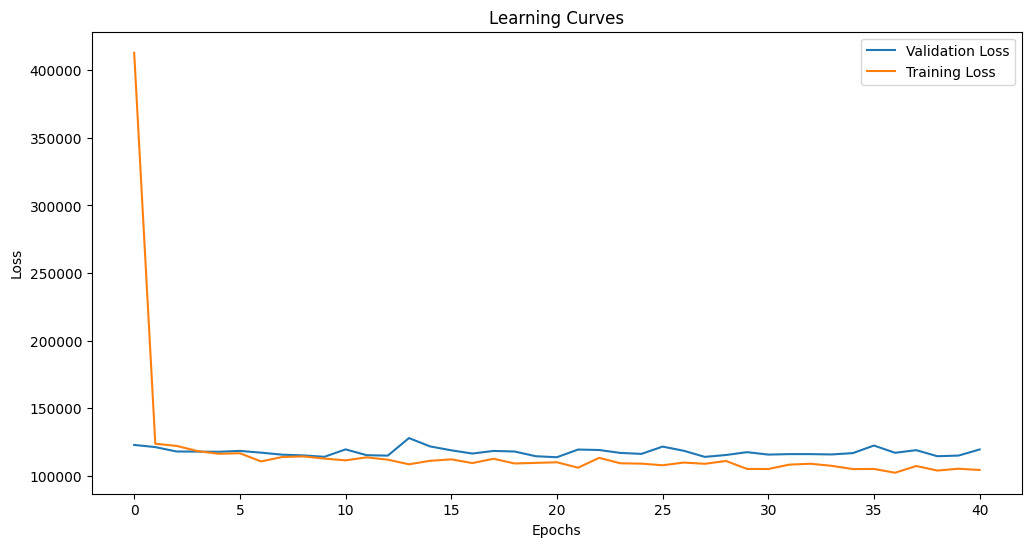

In [ ]:
# Plotting learning curves
def plot_learning_curve(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.plot(history.history['loss'], label='Training Loss')
    plt.title("Learning Curves")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

plot_learning_curve(history)

**test samples**

In [25]:
# Example test sample
sample_data = {
    "Age": [25],
    "Weight (kg)": [70],
    "Height (m)": [1.75],
    "Max_BPM": [190],
    "Avg_BPM": [150],
    "Resting_BPM": [70],
    "Session_Duration (hours)": [1.5],
    "Experience_Level": [2],
    "Workout_Frequency (days/week)": [4],
    "Fat_Percentage": [20],
    "BMI": [22.86],
    "Water_Intake (liters)": [2.5],
    "Gender_Male": [1],
    "Workout_Type_Hiit": [0],
    "Workout_Type_Strength": [0],
    "Workout_Type_Yoga": [0],
}

# Convert to DataFrame
sample_df = sample_df[X.columns]

# Scale the sample
sample_scaled = scaler.transform(sample_df)

# Predict the calories burned
predicted_calories = model.predict(sample_scaled)

print(f"Predicted Calories Burned: {predicted_calories[0][0]:.2f}")


# Example test sample
sample_data_2 = {
    "Age": [30],
    "Weight (kg)": [80],
    "Height (m)": [1.80],
    "Max_BPM": [185],
    "Avg_BPM": [160],
    "Resting_BPM": [65],
    "Session_Duration (hours)": [2.0],
    "Experience_Level": [3],
    "Workout_Frequency (days/week)": [5],
    "Fat_Percentage": [18],
    "BMI": [24.69],
    "Water_Intake (liters)": [3.0],
    "Gender_Male": [1],
    "Workout_Type_Hiit": [1],
    "Workout_Type_Strength": [0],
    "Workout_Type_Yoga": [0],
}

# Convert to DataFrame
sample_df_2 = pd.DataFrame(sample_data_2)

# Align columns with the training dataset
sample_df_2 = sample_df_2[X.columns]

# Scale the sample
sample_scaled_2 = scaler.transform(sample_df_2)

# Predict the calories burned
predicted_calories_2 = model.predict(sample_scaled_2)

print(f"Predicted Calories Burned: {predicted_calories_2[0][0]:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted Calories Burned: 895.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted Calories Burned: 1062.77
